In [1]:
import sys
sys.path.insert(1, '../')
#
import math
import numpy as np              # scientific computing tools
import wrappers                 # for compilation of Fortran Hamiltonian codes
import geometry2d.database
import geometry2d.conjugate
import geometry2d.errors
import geometry2d.geodesic
import geometry2d.plottings
import geometry2d.problem
import geometry2d.splitting
import geometry2d.utils
import geometry2d.wavefront
import geometry2d.sphere
import nutopy as nt
import scipy
import matplotlib.pyplot as plt # for plots
%matplotlib inline

In [2]:
#
color_hyperbolic_2D = 'red'
color_hyperbolic_3D = (1.0, 0.2, 0.2)
color_elliptic_2D = 'blue'
color_elliptic_3D = (0.2, 0.2, 1.0)
color_abnormal_2D = (0.2, 0.8, 0.2) #'green'
color_abnormal_3D = (0.2, 1.0, 0.2)
color_cut_locus  = 'black'
color_conjugate  = 'magenta'
color_wavefront  = 'orange'
color_sphere     = 'orange'
#
color_strong_domain_2d = 'lightblue'
color_strong_domain_3d = 'black'
#
PLANE = geometry2d.plottings.Coords.PLANE
SPHERE = geometry2d.plottings.Coords.SPHERE

## Fortran Hamiltonian code

In [3]:
# print Fortran code of the Hamiltonian: print hfun.f90 file
with open('hfun.f90', 'r') as f:
    print(f.read())

! Landau
subroutine hfun(x, p, c, h)

    double precision, intent(in)  :: x(2), p(2), c(2)
    double precision, intent(out) :: h

    ! local variables
    double precision :: r, th, pr, pth
    double precision :: m2, a, g1, g2, g3, cr, sr, ct, st, mu1, mu2

    r   = x(1)
    th  = x(2)

    pr  = p(1)
    pth = p(2)

    cr = cos(r)
    sr = sin(r)
    ct = cos(th)
    st = sin(th)

    g1 = c(1)
    g2 = c(2)
    g3 = c(3)
    a  = c(4)

    mu1 = a*g1*cs*sr+(g2-g3)*ct*st*sr-a*(g2*ct**2+g3*st**2)*cr*sr 
    mu2 = a*(g2-g3)*ct*st-g1*cr+(g3*st**2+g2*ct**2)*cr

    m2   = sin(r)**2

    h   = mu1*pr + mu2*pth + sqrt(pr**2 + pth**2/m2)

end subroutine hfun


In [4]:
def m2(r):
    return np.sin(r)**2

def g2_Landau(r):
    return m2(r)

def initialize(θ0, r0, γ1, γ2, γ3, α):

    # Parameters
    λ = np.array([γ1, γ2, γ3, α]) # parameters of the Hamiltonian
    t0 = 0.0        # initial time

    name = 'landau' # name of the problem

    # Initialize data
    data_file = 'data_landau.json'
    restart   = False # restart or not the computations
    data      = geometry2d.database.Data({'name': name,
                        't0': t0, 
                        'r0': r0, 
                        'θ0': θ0, 
                        'λ': λ}, data_file, restart)

    # Initial point
    q0 = np.array([r0, θ0])

    # Hamiltonian and derivatives up to order 3
    H = wrappers.hamiltonian(λ, compile=False, display=False)

    # The Riemannian metric associated to the Zermelo problem
    # g = g1 dr^2 + g2 dθ^2
    def g(q):
        r  = q[0] 
        g1 = 1.0
        g2 = g2_Landau(r)
        return g1, g2

    # problem
    prob = geometry2d.problem.GeometryProblem2D(name, H, g, t0, q0, data, steps_for_geodesics=200)
    
    return prob

In [73]:
# strong current if F(r, θ) > 1
def F_current(r, θ, γ1, γ2, γ3, α):
    c = 1 + α**2
    γ13 = γ1 - γ3
    γ23 = γ2 - γ3
    F = c*np.sin(r)**2 * ( γ23**2 * np.sin(2*θ)**2 / 4 + np.cos(r)**2 * (γ13 - γ23 * np.cos(θ)**2)**2 )
    return np.sqrt(F)

def F_classical(θ, γ1, γ2, γ3, α):
    c = 1 + α**2
    γ13 = γ1 - γ3
    γ23 = γ2 - γ3
    K23 = c * γ23**2 / 4.0
    a = K23 * np.sin(2*θ)**2
    b = c * (γ13 - γ23 * np.cos(θ)**2)**2 / 4.0
    return a/(4.0*b)

def R_max_current(θ, γ1, γ2, γ3, α):
    F = F_classical(θ, γ1, γ2, γ3, α)
    if F <= 1.0:
        α0 = np.arccos(-F)
        return α0/2.0
    else:
        return np.pi/2.0
    
def F_max_current(θ, γ1, γ2, γ3, α):
    r = R_max_current(θ, γ1, γ2, γ3, α)
    return F_current(r, θ, γ1, γ2, γ3, α)

def case(γ1, γ2, γ3, α):
    
    #
    F_current_max   = -1
    F_classical_max = -1
    F_min_max       = -1

    #
    N = 100
    rs = np.linspace(0.0, np.pi, N)
    θs = np.linspace(0.0, 2.0*np.pi, N)
    
    # Check if there exists domain of strong current
    R, Θ = np.meshgrid(rs, θs)
    F = np.zeros_like(R)
    for i, j in np.ndindex(R.shape):
        F[i,j] = F_current(R[i,j], Θ[i,j], γ1, γ2, γ3, α)
    F_current_max = np.max(F)
    
    if F_current_max <= 1.0:    
        # weak current case
        print('There is no domain of strong current')
    else:
        # strong current case
        print('There is a domain of strong current')
            
        # Check if revolution case or not
        if γ2 == γ3:
            print('Revolution case')
        else:
            print('Non revolution case')
            
            # check if classical case (case A) or not
            F = np.zeros_like(θs)
            for i in range(N):
                F[i] = F_classical(θs[i], γ1, γ2, γ3, α)
            F_classical_max = np.max(F)
            
            if F_classical_max <= 1.0:
                print('Classical case')
            else:
                print('Non classical case')
                
                # check if case B1 (B weak) or B2 (B strong)
                F = np.zeros_like(θs)
                for i in range(N):
                    F[i] = F_max_current(θs[i], γ1, γ2, γ3, α)
                F_min_max = np.min(F)
                
                if F_min_max <= 1.0:
                    print('Case B1: B weak')
                else:
                    print('Case B2: B strong')
            
    return F_current_max, F_classical_max, F_min_max

def plot_F_contour(γ1, γ2, γ3, α):
    
    #
    N = 200
    rs = np.linspace(0.0, np.pi, N)
    θs = np.linspace(0.0, 2.0*np.pi+0.1, N)
    
    R, Θ = np.meshgrid(rs, θs)
    F = np.zeros_like(R)
    for i, j in np.ndindex(R.shape):
        F[i,j] = F_current(R[i,j], Θ[i,j], γ1, γ2, γ3, α)
    F_current_max = np.max(F)
    
    fig, ax = plt.subplots()
    
    # plot the surface with a view 'from above' in the (θ, r) plane
    #ax.plot_surface(Θ, R, F, cmap='viridis', edgecolor='none')    
    
    # add colorbar
    fig.colorbar(ax.pcolor(Θ, R, F, cmap='plasma', vmin=0.0, vmax=F_current_max))
    
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$r$')
    
    # levels
    ax.contour(Θ, R, F, levels=[1.0], colors='cyan')
    
    # set xlims and ylims
    ax.set_xlim([0.0, 2.0*np.pi])
    ax.set_ylim([0.0, np.pi])
    
    # x ticks
    # γ13 = γ1 - γ3
    # γ23 = γ2 - γ3
    # nu = γ13 / (2*γ13 - γ23)
    # if nu > 0.0 and nu < 1.0:
    #     θ0 = np.arccos(np.sqrt(nu))
    #     ax.set_xticks([0.0, θ0, np.pi, 2*np.pi])
    #     ax.set_xticklabels([r'$0$', r'$\theta_0$', r'$\pi$', r'$2\pi$'])
    # else:
    # set xticks: 0, pi and 2pi
    ax.set_xticks([0.0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
            
    # set yticks: 0 => \pi/2, pi/2 => \pi, -pi/2 => 0
    ax.set_yticks([0.0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
    ax.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])

        
    return fig, ax

## Cas de révolution

There is a domain of strong current
Revolution case
F_current_max   =  1.1178932592110442
F_classical_max =  -1
F_min_max       =  -1


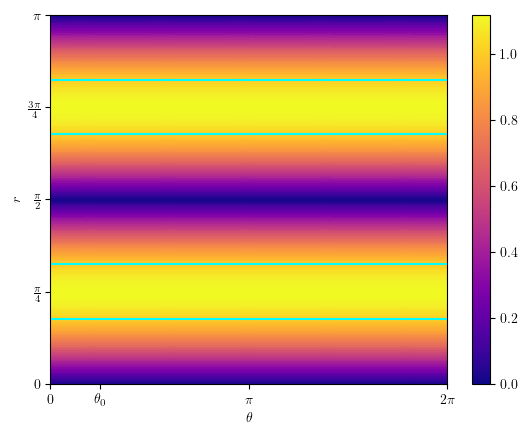

In [27]:
γ1, γ2, γ3, α = 1.0, 2.0, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

## On augmente $\gamma_3$ depuis le cas de révolution

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.3414251592554134
F_classical_max =  0.008329955867324107
F_min_max       =  -1


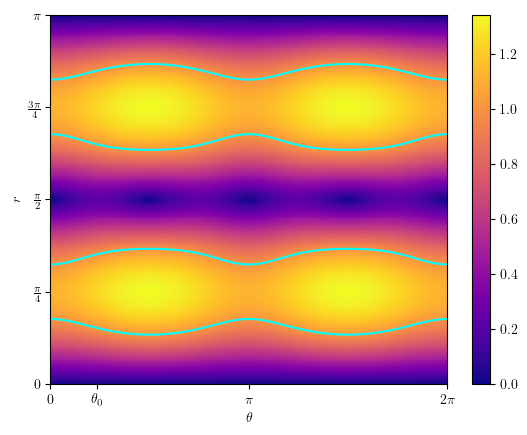

In [33]:
γ1, γ2, γ3, α = 1.0, 2.0, 2.2, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.676746834287798
F_classical_max =  0.041635613054817826
F_min_max       =  -1


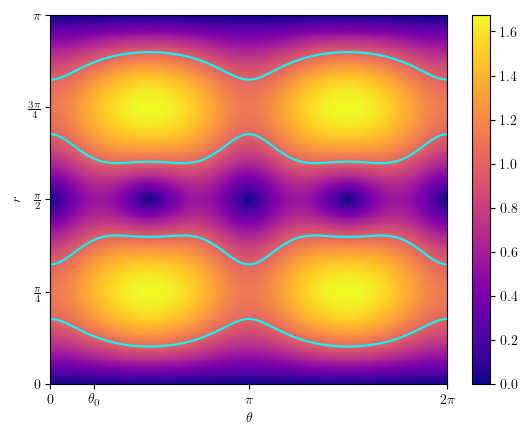

In [34]:
γ1, γ2, γ3, α = 1.0, 2.0, 2.5, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  2.012084393555283
F_classical_max =  0.08887556115603763
F_min_max       =  -1


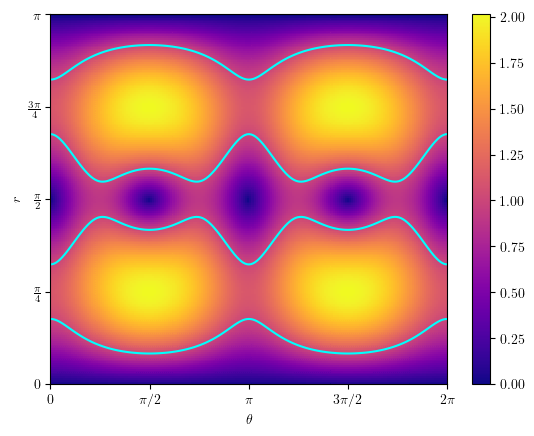

In [78]:
γ1, γ2, γ3, α = 1.0, 2.0, 2.8, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  2.123865809392287
F_classical_max =  0.10655564316930861
F_min_max       =  -1


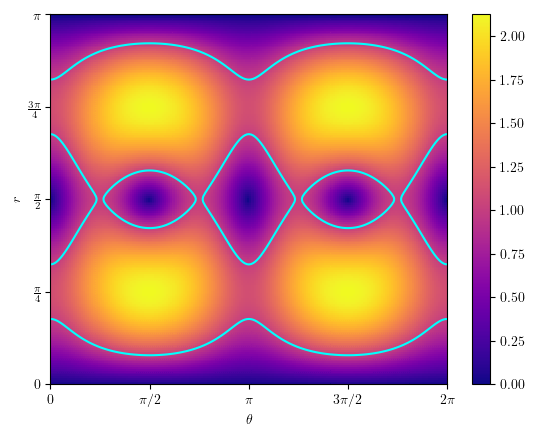

In [79]:
γ1, γ2, γ3, α = 1.0, 2.0, 2.9, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  2.2356480612636003
F_classical_max =  0.12491066756984616
F_min_max       =  -1


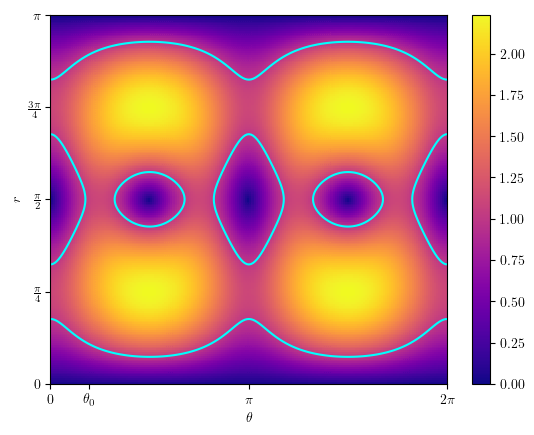

In [35]:
γ1, γ2, γ3, α = 1.0, 2.0, 3.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B2: B strong
F_current_max   =  6.707143797661985
F_classical_max =  1.0412681382267113
F_min_max       =  1.118033988749895


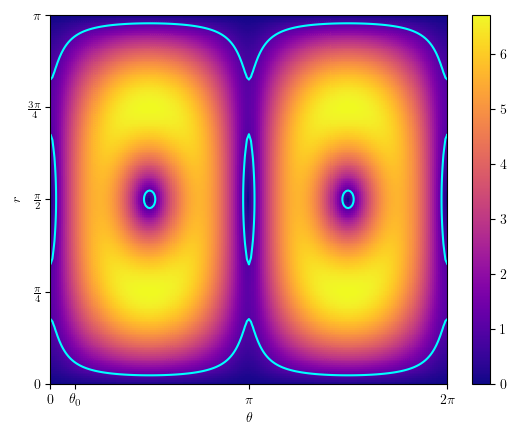

In [39]:
γ1, γ2, γ3, α = 1.0, 2.0, 7.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B2: B strong
F_current_max   =  21.239782069236743
F_classical_max =  4.2621178363222425
F_min_max       =  1.118033988749895


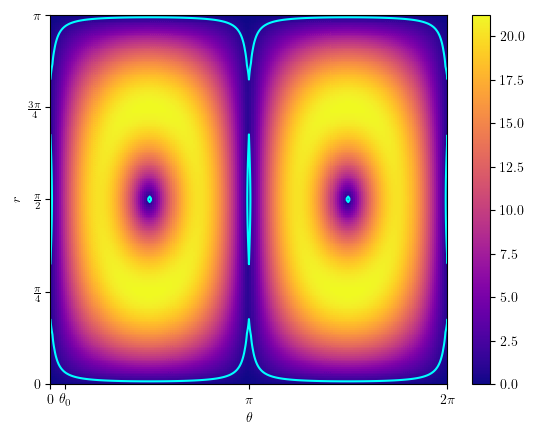

In [41]:
γ1, γ2, γ3, α = 1.0, 2.0, 20.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

## On augmente $\gamma_2$ depuis le cas de révolution

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.2296825851321487
F_classical_max =  0.002270436116182412
F_min_max       =  -1


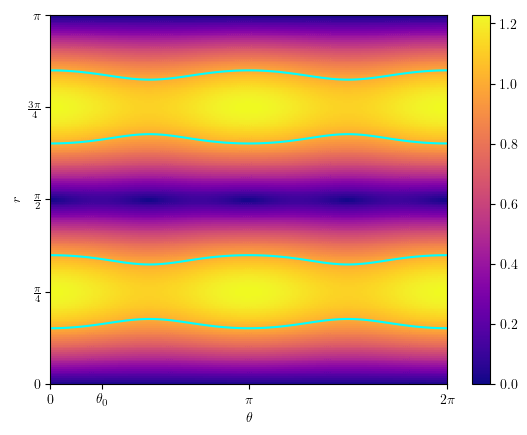

In [44]:
γ1, γ2, γ3, α = 1.0, 2.1, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.676839888816566
F_classical_max =  0.041665620008689876
F_min_max       =  -1


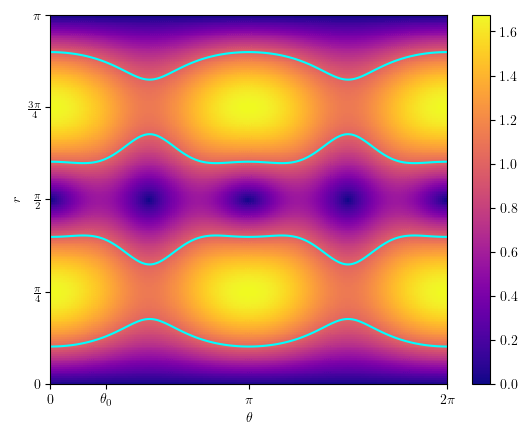

In [45]:
γ1, γ2, γ3, α = 1.0, 2.5, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  2.012207866579879
F_classical_max =  0.08885033552777799
F_min_max       =  -1


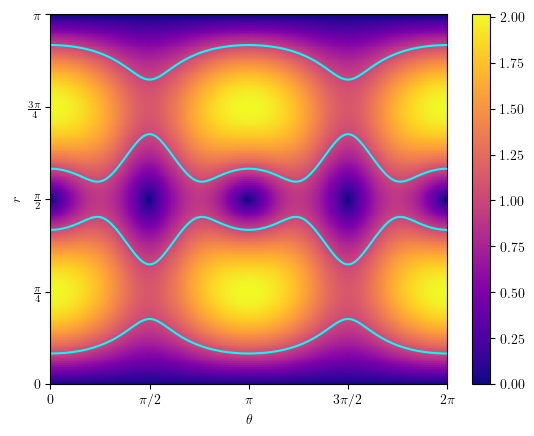

In [80]:
γ1, γ2, γ3, α = 1.0, 2.8, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  2.1239971925009837
F_classical_max =  0.10654202628678702
F_min_max       =  -1


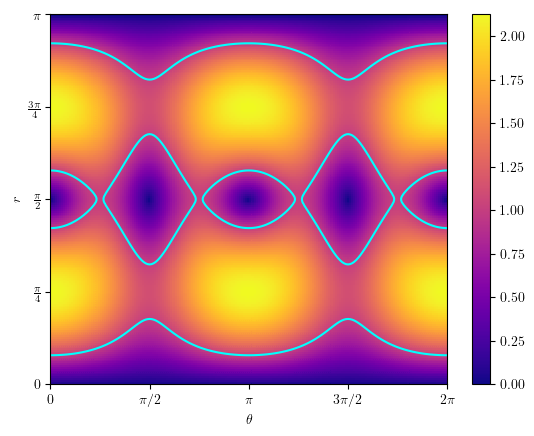

In [81]:
γ1, γ2, γ3, α = 1.0, 2.9, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  2.2357865184220884
F_classical_max =  0.12499381883782183
F_min_max       =  -1


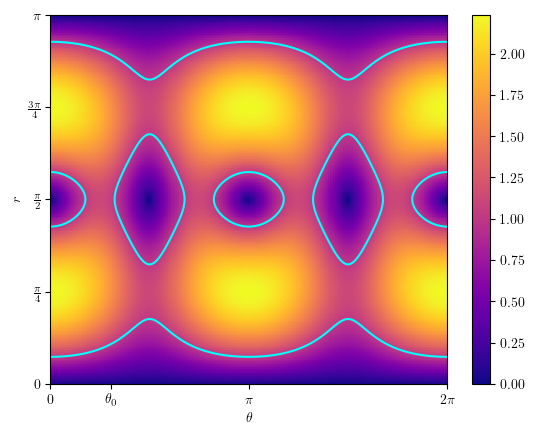

In [46]:
γ1, γ2, γ3, α = 1.0, 3.0, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  4.471573036844177
F_classical_max =  0.5624563263092872
F_min_max       =  -1


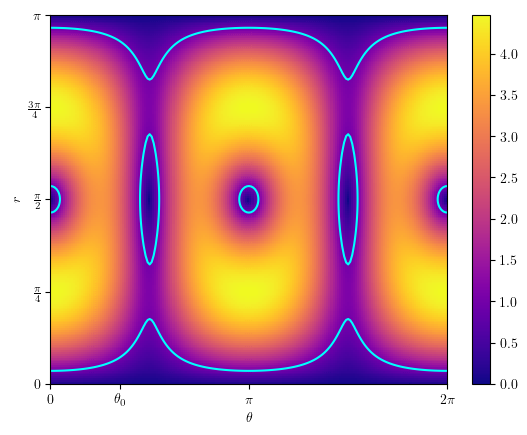

In [47]:
γ1, γ2, γ3, α = 1.0, 5.0, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B2: B strong
F_current_max   =  21.23997192500984
F_classical_max =  4.249879513816367
F_min_max       =  1.2138527688990721


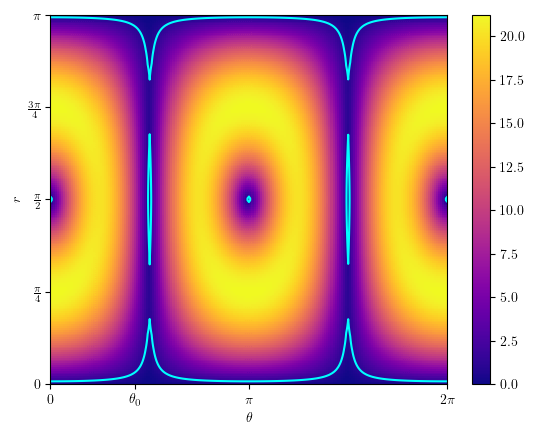

In [48]:
γ1, γ2, γ3, α = 1.0, 20.0, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

## On augmente $\gamma_1$ et $\gamma_2$ depuis le cas de révolution

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.1178932592110442
F_classical_max =  0.0027757930946508353
F_min_max       =  -1


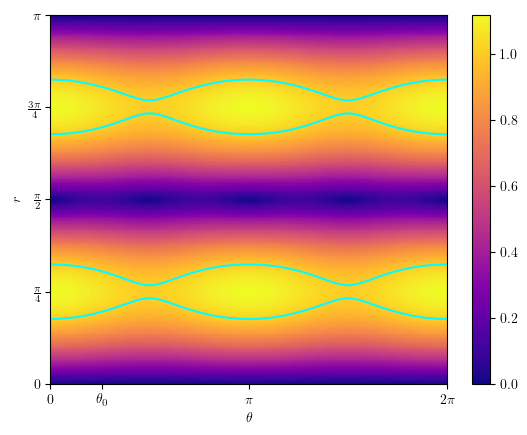

In [54]:
γ1, γ2, γ3, α = 1.1, 2.1, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.1178932592110444
F_classical_max =  0.01248743485523893
F_min_max       =  -1


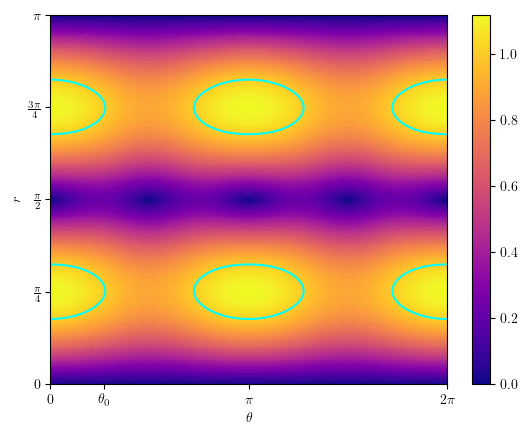

In [55]:
γ1, γ2, γ3, α = 1.2, 2.2, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.117893259211044
F_classical_max =  0.03211507676053083
F_min_max       =  -1


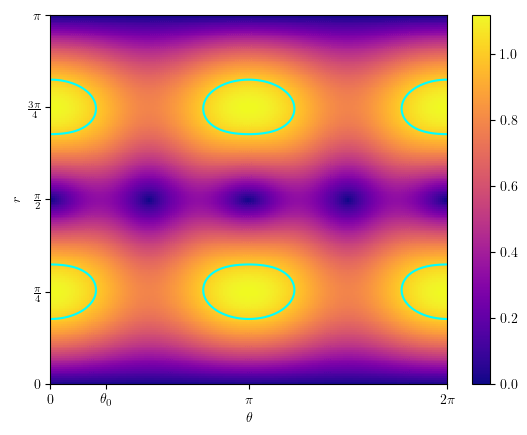

In [56]:
γ1, γ2, γ3, α = 1.3, 2.3, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.1178932592110442
F_classical_max =  0.2249175970011809
F_min_max       =  -1


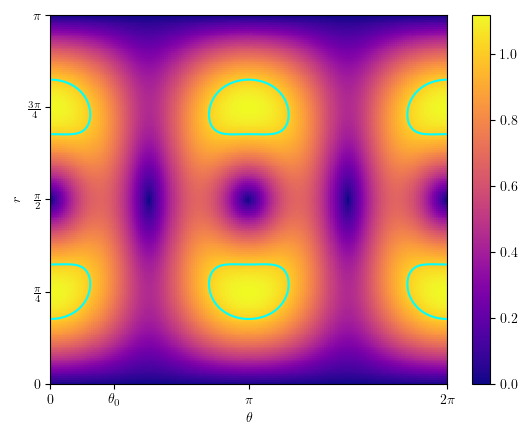

In [58]:
γ1, γ2, γ3, α = 1.6, 2.6, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.1178932592110444
F_classical_max =  0.40813517869056964
F_min_max       =  -1


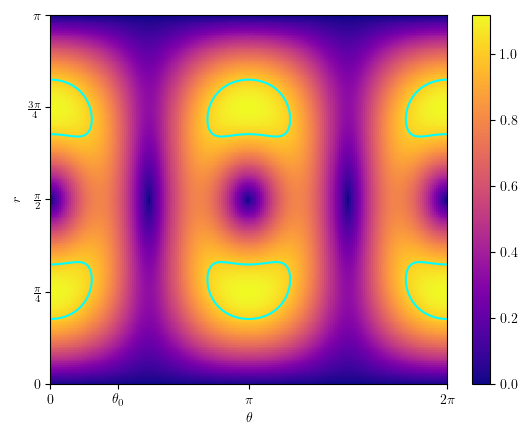

In [59]:
γ1, γ2, γ3, α = 1.7, 2.7, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.117893259211044
F_classical_max =  0.799648749821878
F_min_max       =  -1


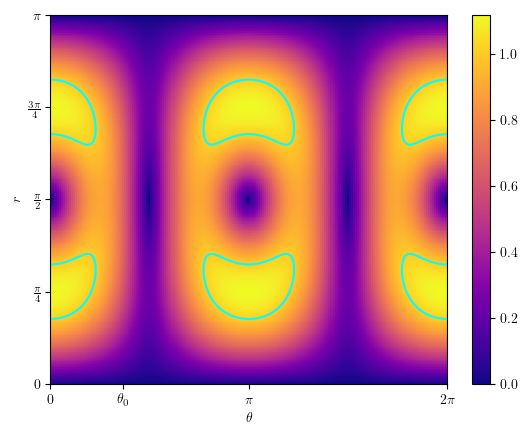

In [60]:
γ1, γ2, γ3, α = 1.8, 2.8, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.1178932592110442
F_classical_max =  1.613332066766387
F_min_max       =  0.13622417901565712


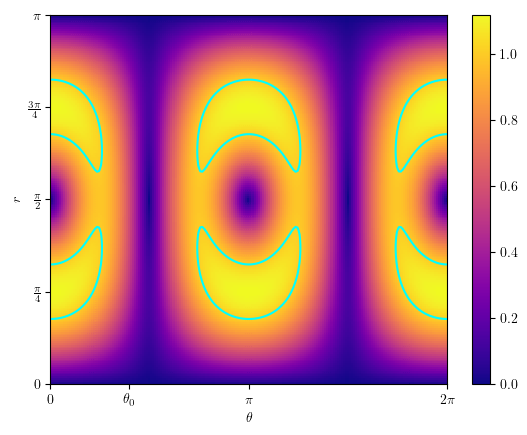

In [65]:
γ1, γ2, γ3, α = 1.88, 2.88, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.1178932592110442
F_classical_max =  2.0244250008244067
F_min_max       =  0.11433064552163047


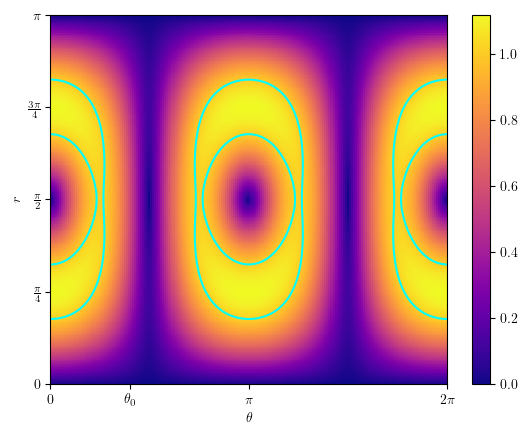

In [66]:
γ1, γ2, γ3, α = 1.9, 2.9, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.1180338929607558
F_classical_max =  3971.5290336317016
F_min_max       =  0.035472908043635266


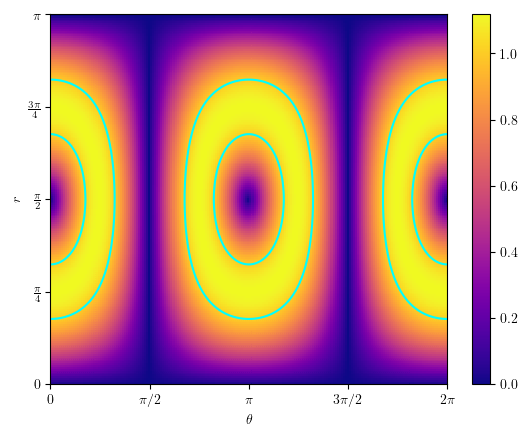

In [67]:
γ1, γ2, γ3, α = 2.0, 3.0, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.67665009485716
F_classical_max =  22749.451015666073
F_min_max       =  0.5598619565701681


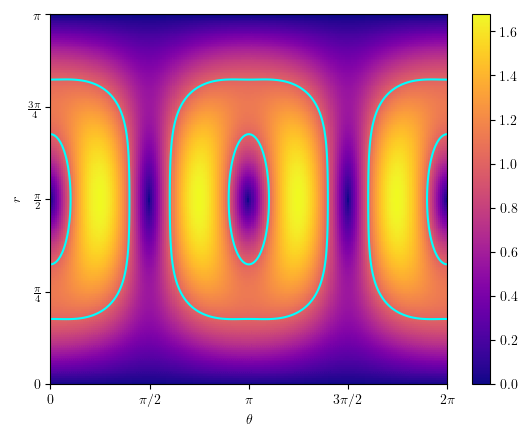

In [68]:
γ1, γ2, γ3, α = 2.5, 3.5, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.9001855010831994
F_classical_max =  1193.1926168491066
F_min_max       =  0.7833077106874666


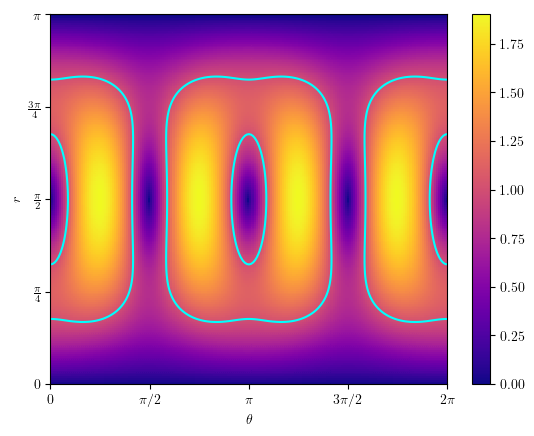

In [75]:
γ1, γ2, γ3, α = 2.7, 3.7, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B2: B strong
F_current_max   =  2.123730201439522
F_classical_max =  1402.492716963708
F_min_max       =  1.0068250597826855


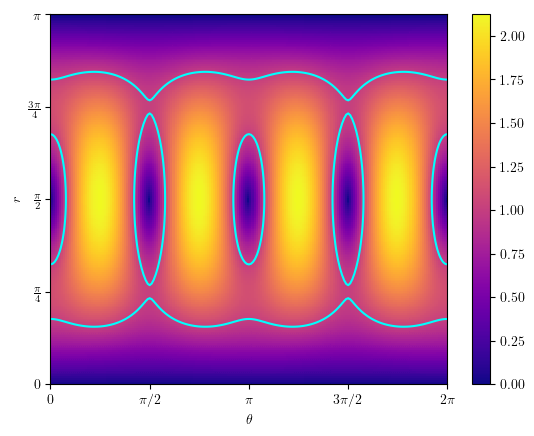

In [77]:
γ1, γ2, γ3, α = 2.9, 3.9, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B2: B strong
F_current_max   =  2.2355051656191938
F_classical_max =  3971.529033631682
F_min_max       =  1.118033988749895


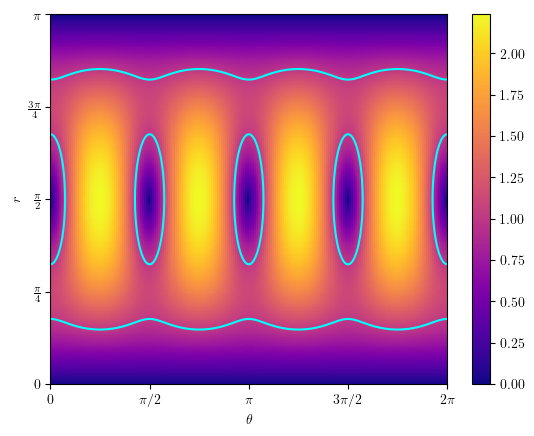

In [74]:
γ1, γ2, γ3, α = 3.0, 4.0, 2.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

## On augmente $\gamma_1$ et $\gamma_3$ depuis le cas de révolution

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.1178679773926907
F_classical_max =  0.0027777065908489284
F_min_max       =  -1


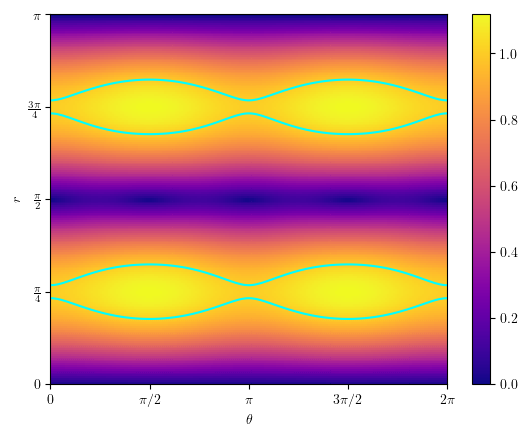

In [82]:
γ1, γ2, γ3, α = 1.1, 2.0, 2.1, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.117848413369244
F_classical_max =  0.012499999045631378
F_min_max       =  -1


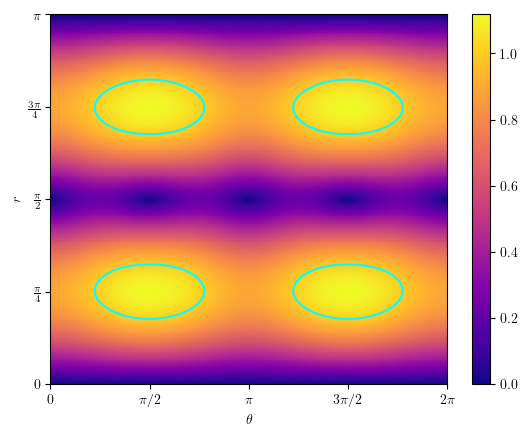

In [83]:
γ1, γ2, γ3, α = 1.2, 2.0, 2.2, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.1178273399127157
F_classical_max =  0.2249423564074874
F_min_max       =  -1


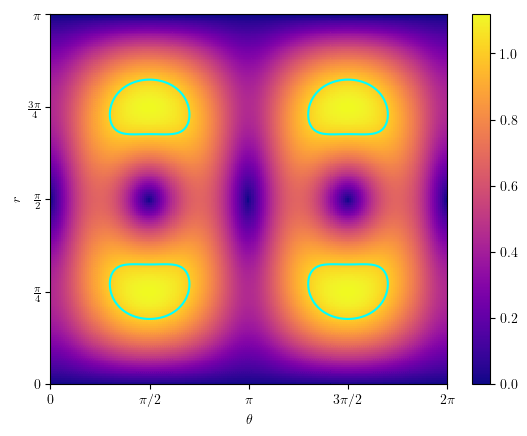

In [84]:
γ1, γ2, γ3, α = 1.6, 2.0, 2.6, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Classical case
F_current_max   =  1.1178511135915616
F_classical_max =  0.7996259134715119
F_min_max       =  -1


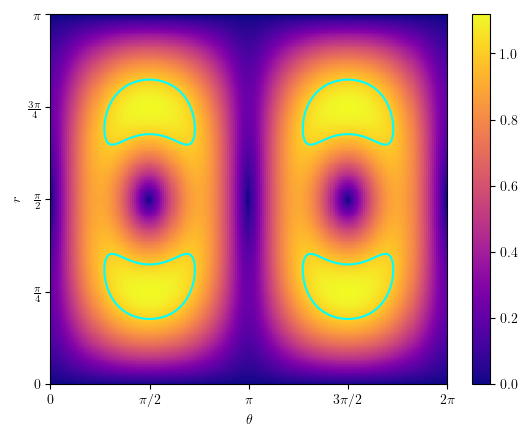

In [85]:
γ1, γ2, γ3, α = 1.8, 2.0, 2.8, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.1178670273875526
F_classical_max =  1.609394893614383
F_min_max       =  0.1341640786499875


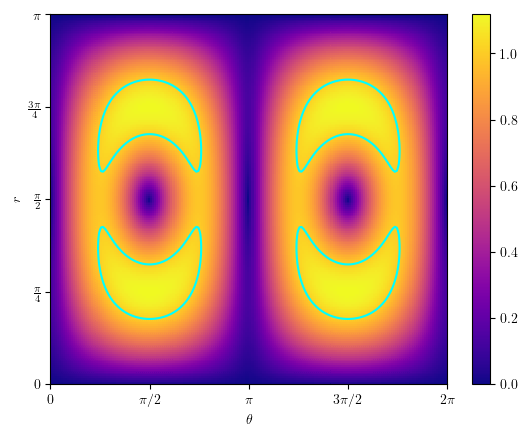

In [86]:
γ1, γ2, γ3, α = 1.88, 2.0, 2.88, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.1178715776246562
F_classical_max =  2.0220992466058094
F_min_max       =  0.11180339887498958


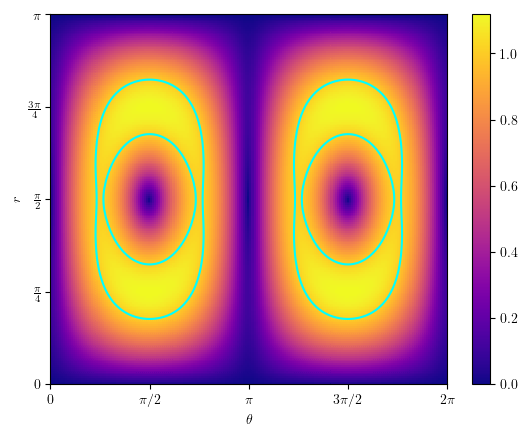

In [87]:
γ1, γ2, γ3, α = 1.9, 2.0, 2.9, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.1180334437811648
F_classical_max =  nan
F_min_max       =  0.0


/var/folders/tv/h4108j4n2fqgsh9zdn1n__c80000gn/T/ipykernel_3170/2862589150.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return a/(4.0*b)
/var/folders/tv/h4108j4n2fqgsh9zdn1n__c80000gn/T/ipykernel_3170/2862589150.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return a/(4.0*b)


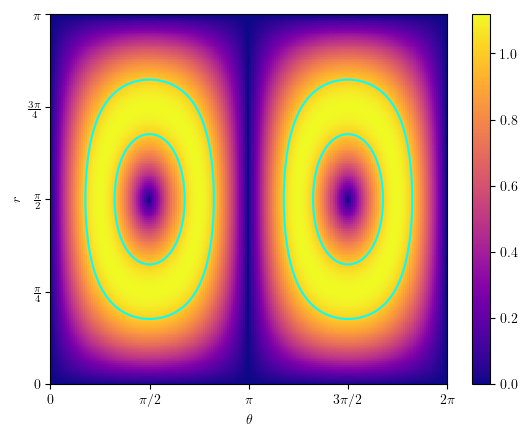

In [88]:
γ1, γ2, γ3, α = 2.0, 2.0, 3.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.6766545601330556
F_classical_max =  1573.0513630268351
F_min_max       =  0.5590169943749475


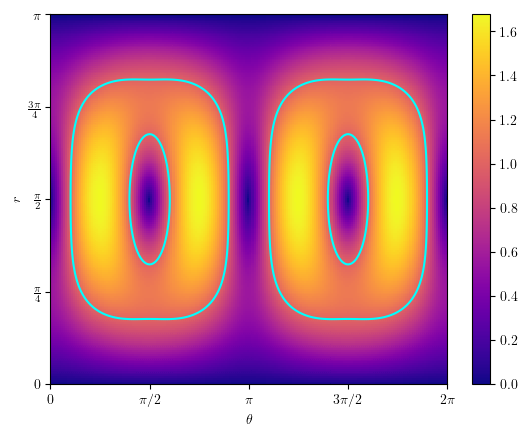

In [89]:
γ1, γ2, γ3, α = 2.5, 2.0, 3.5, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B1: B weak
F_current_max   =  1.9001881802757097
F_classical_max =  121748.19708104694
F_min_max       =  0.7826237921249266


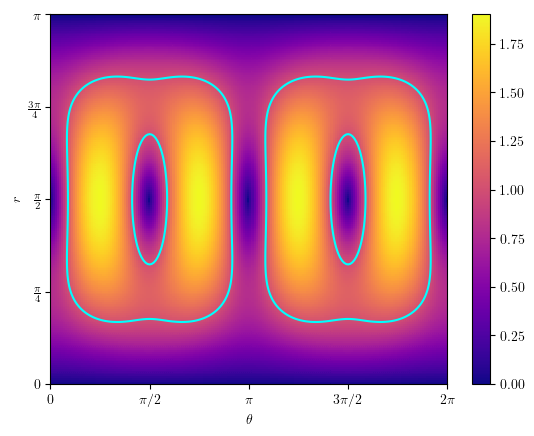

In [90]:
γ1, γ2, γ3, α = 2.7, 2.0, 3.7, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B2: B strong
F_current_max   =  2.123731094506882
F_classical_max =  39128.28502825846
F_min_max       =  1.0062305898749053


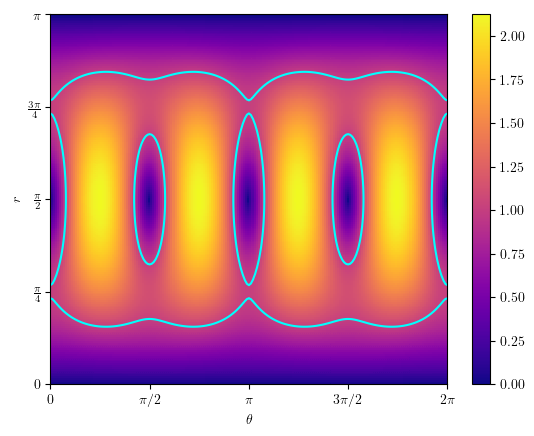

In [91]:
γ1, γ2, γ3, α = 2.9, 2.0, 3.9, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)

There is a domain of strong current
Non revolution case
Non classical case
Case B2: B strong
F_current_max   =  2.2355051656191938
F_classical_max =  3971.529033631682
F_min_max       =  1.118033988749895


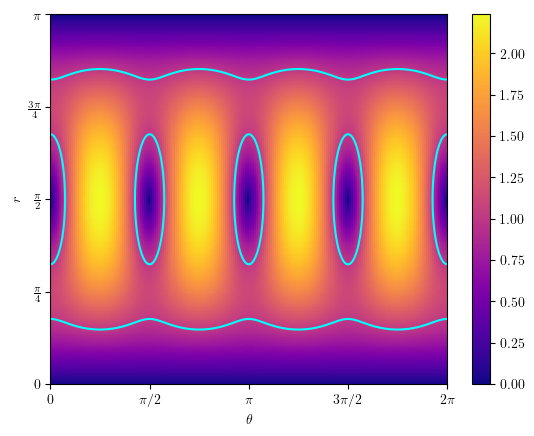

In [92]:
γ1, γ2, γ3, α = 3.0, 2.0, 4.0, 2.0
F_current_max, F_classical_max, F_min_max = case(γ1, γ2, γ3, α)
print('F_current_max   = ', F_current_max)
print('F_classical_max = ', F_classical_max)
print('F_min_max       = ', F_min_max)

fig, ax = plot_F_contour(γ1, γ2, γ3, α)